# Predict_Future_HIA_Simple
This notebook estimates future premature mortality due to smoke pollution among residents of Kearney, Nebrasaka.  The prediction model is based on a simple linear regresssion model of fire related PM25 pollution, constructed from the yearly PM 25 pollution estiamtes from the O'Dell et. al data for 2006-2018. Confidence intervals are consutructed using bootstrapping to account for the commbined uncertainty in: (1) future fire-related soke pollution estimates and (2) Beta values in the Health Impact Assessment equations.  


# License 
This code was developed by Susan Boyd for use in HW1 assigned in DATA 512, a course in the UW MS Data Science degree program. This code is provided under an MIT license.


# Step 0 set up notebook 

In [1]:
# import needed libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
import seaborn as sns

# Step 1 Load Data 

Load annual smoke PM25 impact based on O'Dell data 

In [2]:
f = "Data\Annual Summary PM25 Data ODell.csv"
impact_df = pd.read_csv(f)
impact_df["Ave Impact Per Day"] = impact_df["Diff in Mean PM25"]*impact_df["Num Smoke Days"]/365
impact_df.tail()

,Year,Mean PM25 Smoke Days,Mean PM25 Non-Smoke Days,Diff in Mean PM25,Num Smoke Days,Avg. Annual Delta_PM25,Annual Mean Combined,Ave Impact Per Day
8,2014,9.711379,7.430915,2.280464,41.0,0.256162,7.687077,0.256162
9,2015,9.982605,6.395674,3.586932,46.0,0.452052,6.847725,0.452052
10,2016,6.636919,5.287996,1.348923,45.0,0.166306,5.453848,0.166306
11,2017,7.511007,5.361542,2.149465,53.0,0.312114,5.673656,0.312114
12,2018,9.079763,5.503789,3.575974,63.0,0.617223,6.121012,0.617223


Load Kearney population data and projections 

In [3]:
f = "Data\Kearney_Pop.csv"
KEARNEY_POP = pd.read_csv(f)
KEARNEY_POP.head()

,Year,Pop
0,2000,27431
1,2001,27749
2,2002,28072
3,2003,28397
4,2004,28727


# Step 2 - Make a Smoke Impact Model

In [4]:
# OLS regression using sklearn 
x1 = impact_df["Year"] 
x2 = np.ones(len(x1))
y = impact_df[["Ave Impact Per Day"]]
X = pd.DataFrame({'Year': x1, 'Constant': x2})


#build linear regression model
model_OLS = LinearRegression()
model_OLS.fit(X, y)

# Coefficients and intercept
coefficients = model_OLS.coef_
intercept = model_OLS.intercept_

# R-squared score
r_squared = model_OLS.score(X, y)

# Make predictions using the model
y_pred = model_OLS.predict(X)

# Calculate the Mean Squared Error
mse = mean_squared_error(y, y_pred)

# Print the results
print("Coefficients:", coefficients)
print("Intercept:", intercept)
print("R-squared:", r_squared)
print("Mean Squared Error on train set :", mse)

Coefficients: [[0.03350763 0.        ]]
Intercept: [-67.13813792]
R-squared: 0.33368702115234916
Mean Squared Error on train set : 0.031387335413922655


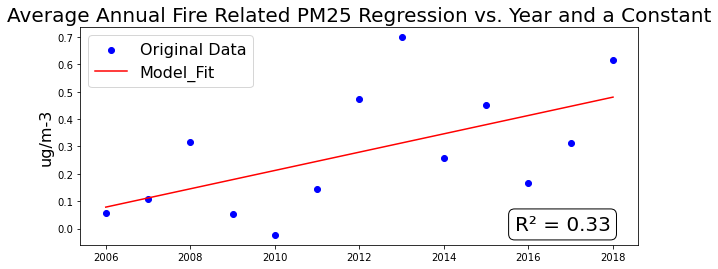

In [5]:
# graph the results of the model 
 # Plot the original data and the model fit
    
    
fig, ax = plt.subplots(figsize=(10, 4))
plt.scatter(X["Year"], y, label='Original Data', color='blue')
plt.plot(X["Year"], model_OLS.predict(X), color='red', label='Model_Fit')
plt.legend(fontsize = 16)
plt.annotate(f'R² = {r_squared:.2f}', xy=(0.95, 0.05), xycoords='axes fraction',
             ha='right', va='bottom', fontsize=20, color='black', bbox=dict(boxstyle='round', facecolor='white', edgecolor='black'))

plt.ylabel("ug/m-3", fontsize = 16)



# Save the plot as a JPG file
f_out = "Visuals/Figure 11.jpg"
plt.savefig(f_out)
plt.savefig(f_out, bbox_inches="tight", pad_inches=0.1)

# Add title and display 
t = "Average Annual Fire Related PM25 Regression vs. Year and a Constant"
plt.title(t, fontsize = 20) 
plt.show(); 



# Step 3 - Prediction Smoke Impacts & CI

Define a function that creates bootsrapped confidence intervals given a model, X, y, new_X

In [6]:
# Create bootstrapped CIs for model
# See Chat GPT Attribution Note at end of Notebook 


def calc_CI (X, y, new_X, model, number = 1000):

    # Number of bootstrap iterations
    n_bootstrap = number

    # Initialize arrays to store bootstrapped results
    b_results = pd.DataFrame({"Year": new_X["Year"]})

    # Perform bootstrapping
    for i in range(n_bootstrap):
        # Resample data with replacement
        sample_indices = np.random.choice(X.shape[0], X.shape[0], replace=True).tolist()
        sample_indices.sort()
        resampled_X = X.iloc[sample_indices]
        resampled_y = y.iloc[sample_indices]

        # Fit the model to the resampled data
        model.fit(resampled_X, resampled_y)
    
        # Predict y values for new_x
        predicted_y = model.predict(new_X)
        predicted_y_df = pd.DataFrame(predicted_y, columns=[i])
                
        # Store the results for this iteration
        b_results = pd.concat([b_results, predicted_y_df], axis = 1 )

    
    #Calculate lower and upper percentiles to create confidence intervals
    lower_percentile = 2.5  # Lower bound for 95% confidence interval
    upper_percentile = 97.5  # Upper bound for 95% confidence interval

    cols = b_results.columns.drop("Year")
    lower_bounds = np.percentile(b_results[cols], lower_percentile, axis=1)
    upper_bounds = np.percentile(b_results[cols], upper_percentile, axis=1)

    results = pd.DataFrame ({
        "Year": new_X["Year"],
        "Lower Bounds": lower_bounds,
        "Upper Bounds": upper_bounds
    })
    
    return results 
    

Define a function that creates future predictions, and graphs existing data/model and predictions 

In [7]:
# given a model, an original X, y, and a new X (for prediction)
# graph the original data, the predicted values for the original data, and the 
# predicted values for the new X 

def graph_and_predict(model, X, y, new_X, number = 1000):

    # create the new predictins 
    new_y = model.predict(new_X)
    results = pd.DataFrame(new_y, columns = ["Predicted"])
    
    
    # Plot the original data and the model fit
    plt.scatter(X["Year"], y, label='Original Data', color='blue')
    plt.plot(X["Year"], model.predict(X), color='red', label='Model_Fit')
    plt.plot(new_X["Year"], new_y, 'o', color='green', label='Predicted Values')
    
    # Plot the CI interval for the prediction 
    CI = calc_CI(X, y, new_X, model, number = number)
    plt.fill_between(future_years, CI["Lower Bounds"], CI["Upper Bounds"], color='lightgray', label='95% Confidence Interval')
    
    results = pd.concat([results, CI], axis =1)

    # Set labels and legend
    plt.xlabel('Year')
    plt.ylabel('Smoke Impact')
    plt.legend(loc='upper left')
    plt.ylim(bottom=0)

    # Show the plot
    plt.show()
    
    return results



Define new_X values for prediction

In [8]:
# Define new_X values for prediction
future_years = list(range(2019, 2030))
x2 = np.ones(len(future_years))
new_X = pd.DataFrame({'Year': future_years, 'Constant': x2})

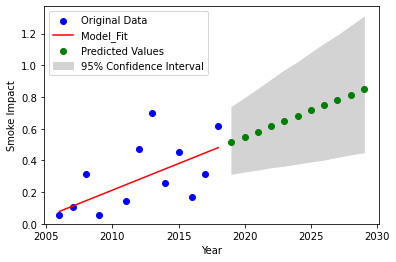

,Predicted,Year,Lower Bounds,Upper Bounds
0,0.513770,2019,0.315436,0.737720
1,0.547277,2020,0.330492,0.792521
2,0.580785,2021,0.342334,0.849519
3,0.614292,2022,0.357335,0.908861
4,0.647800,2023,0.366740,0.967614


In [9]:
# calculate and graph the impact estimates
impact_est = graph_and_predict(model_OLS, X, y, new_X, number = 1000)
impact_est.head()

In [10]:
# save file results if desired 
#f_out = "Data/future_smoke_impact_est_simple.csv"
#impact_est.to_csv(f_out, index = False)

# Step 4 - Predict Future Health Imapacts

Load HIA_Constants

In [11]:
f = "Data\HIA_Constants_Raw\HIA_Constants.xlsx"
HIA_CONSTANTS = pd.read_excel(f)
HIA_CONSTANTS.head()

,Event,Baseline,OR,OR_LOWER,OR_UPPER
0,ER,0.006257,1.07,1.03,1.11
1,Admit,0.001299,1.08,1.03,1.14
2,Mortality,0.007329,1.06,1.04,1.08


In [12]:
# Set_Betas From OR; display results
col = HIA_CONSTANTS["OR"] 
HIA_CONSTANTS["Beta"] = np.log(col)/10
col = HIA_CONSTANTS["OR_LOWER"] 
HIA_CONSTANTS["Beta_CI_Lower"] =  np.log(col)/10
col = HIA_CONSTANTS["OR_UPPER"] 
HIA_CONSTANTS["Beta_CI_Upper"] =  np.log(col)/10
HIA_CONSTANTS

,Event,Baseline,OR,OR_LOWER,OR_UPPER,Beta,Beta_CI_Lower,Beta_CI_Upper
0,ER,0.006257,1.07,1.03,1.11,0.006766,0.002956,0.010436
1,Admit,0.001299,1.08,1.03,1.14,0.007696,0.002956,0.013103
2,Mortality,0.007329,1.06,1.04,1.08,0.005827,0.003922,0.007696


Define a function to calculate HIA estimate given a single cause type and Beta 

In [13]:
def calc_annual_impact_single_Beta(Year, event, delta_PM25, Beta):
    baseline = HIA_CONSTANTS[HIA_CONSTANTS["Event"] == event]["Baseline"]
    beta = Beta
    pop = int(KEARNEY_POP[KEARNEY_POP["Year"]==Year]["Pop"])
    outcome = float(pop*baseline*(1-np.exp(-beta*delta_PM25)))
    return (outcome)

Define a function that creates boostrap estimates of the mortality outcome. Each bootstrap sample refits the model with a bootstrapped sample of the data AND randomly draws the value of Beta_mortality from an assumed normal distribution centered on the point estimate of Beta_mortality.


In [14]:
def calc_CI_outcome (X, y, new_X, model, event = "Mortality", number = 10000):

    
    # Sample from a normal distribution centered around the Beta point estimate
    # And assuming the 95% CI covers to standard deviations 
    beta_mean  = HIA_CONSTANTS[HIA_CONSTANTS["Event"] == event]["Beta"]
    beta_CI_low = HIA_CONSTANTS[HIA_CONSTANTS["Event"] == event]["Beta_CI_Lower"]
    beta_CI_high = HIA_CONSTANTS[HIA_CONSTANTS["Event"] == event]["Beta_CI_Upper"]
    st_dev = 0.5*(beta_CI_high-beta_CI_low)
    Beta = np.random.normal(loc=beta_mean, scale=st_dev, size=1)
    
   
    # Number of bootstrap iterations
    n_bootstrap = number

    # Initialize arrays to store bootstrapped results
    b_results = pd.DataFrame({"Year": new_X["Year"]})

    # Perform bootstrapping
    for i in range(n_bootstrap):
        
        if i%1000 == 0:
            print("On iteration:", i)
        
        # Resample data with replacement
        sample_indices = np.random.choice(X.shape[0], X.shape[0], replace=True).tolist()
        sample_indices.sort()
        resampled_X = X.iloc[sample_indices]
        resampled_y = y.iloc[sample_indices]
        
        # Fit the model to the resampled data
        model.fit(resampled_X, resampled_y)
    
        # Predict y values for new_x
        predicted_y = model.predict(new_X)
        #predicted_y_df = pd.DataFrame(predicted_y, columns=[i])
        outcomes = []
        for i in range(new_X.shape[0]):
            Year = new_X.iloc[i]["Year"]
            y_val= predicted_y[i]
            outcome = calc_annual_impact_single_Beta(Year, event, y_val, Beta)
            outcomes.append(outcome)
        
        # Store the results for this iteration
        outcomes = pd.DataFrame(outcomes, columns = [i])
        b_results = pd.concat([b_results, outcomes], axis = 1 )
    
    #Calculate lower and upper percentiles to create confidence intervals
    lower_percentile = 2.5  # Lower bound for 95% confidence interval
    upper_percentile = 97.5  # Upper bound for 95% confidence interval

    cols = b_results.columns.drop("Year")
    lower_bounds = np.percentile(b_results[cols], lower_percentile, axis=1)
    upper_bounds = np.percentile(b_results[cols], upper_percentile, axis=1)
    estimates = np.percentile (b_results[cols], 50, axis=1)
  

    results = pd.DataFrame ({
        "Year": new_X["Year"],
        "Estimate": estimates,
        "Lower Bound": lower_bounds,
        "Upper Bound": upper_bounds
    })
    
    return results 
    

In [15]:
results = calc_CI_outcome (X, y, new_X, model_OLS, event = "Mortality", number = 5000)
results.head()

On iteration: 0
On iteration: 1000
On iteration: 2000
On iteration: 3000
On iteration: 4000


,Year,Estimate,Lower Bound,Upper Bound
0,2019,0.916704,0.566543,1.328119
1,2020,0.985786,0.598437,1.436577
2,2021,1.056411,0.628595,1.549492
3,2022,1.128711,0.658753,1.663646
4,2023,1.201407,0.682243,1.783755


Define a function to graph the results of the HIA estimates, with CI

In [23]:
# Function that takes as an input a dataframe with columns
# "Year", "Estimate", "Lower Bound" and "Upper Bound"
# And creates a graph of  predictions and confidence intervals 

def graph_HIA_predict(df):
    
    # Plot the estimates (historical) and predictions (future) 
    plt.figure(figsize=(10, 4))
    plt.plot(df["Year"], df["Estimate"], label='Estimated/Predicted Value', color='blue', linewidth=3)
    # Plot the CI interval for the prediction 
    plt.fill_between(df["Year"], df["Lower Bound"], df["Upper Bound"], \
                     color='lightgray', label='95% Confidence Interval')
    
    plt.axhline(y=1, color='red', linestyle='--', label='1 Premature Death Per Year')
    
    
    # Set labels and legend
    plt.ylabel('Residents of Kearney', fontsize = 14)
    plt.legend(loc='upper left', fontsize = 14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize = 12)

    # Show the plot
    plt.show()

In [20]:
f = 'Data/historical_impacts.csv'
historical_impacts = pd.read_csv(f)
historical_impacts_mortality = historical_impacts[["Year", "Excess Mortality", "Mortality CI Lower", "Mortality CI Upper"]]
df = historical_impacts_mortality.rename(columns={'Excess Mortality': 'Estimate'})
df = df.rename(columns={'Mortality CI Lower': 'Lower Bound'})
df = df.rename(columns={'Mortality CI Upper': 'Upper Bound'})
df.head()

,Year,Estimate,Lower Bound,Upper Bound
0,2006,0.071605,0.048200,0.094570
1,2007,0.135153,0.090980,0.178491
2,2008,0.404902,0.272621,0.534633
3,2009,0.070977,0.047777,0.093741
4,2010,-0.030750,-0.020697,-0.040615


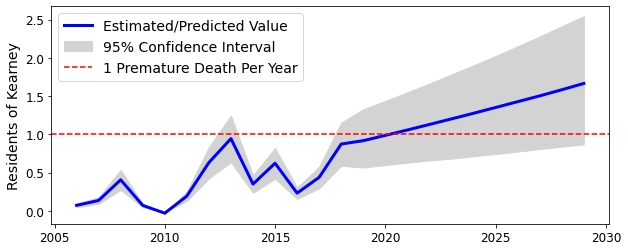

In [24]:
# let's graph combined 2006-2018 + future 
results_all = pd.concat([df, results], axis = 0)
graph_HIA_predict(results_all)
